<a href="https://colab.research.google.com/github/Maher1410/test/blob/main/Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Gridworld Q-Learning ---


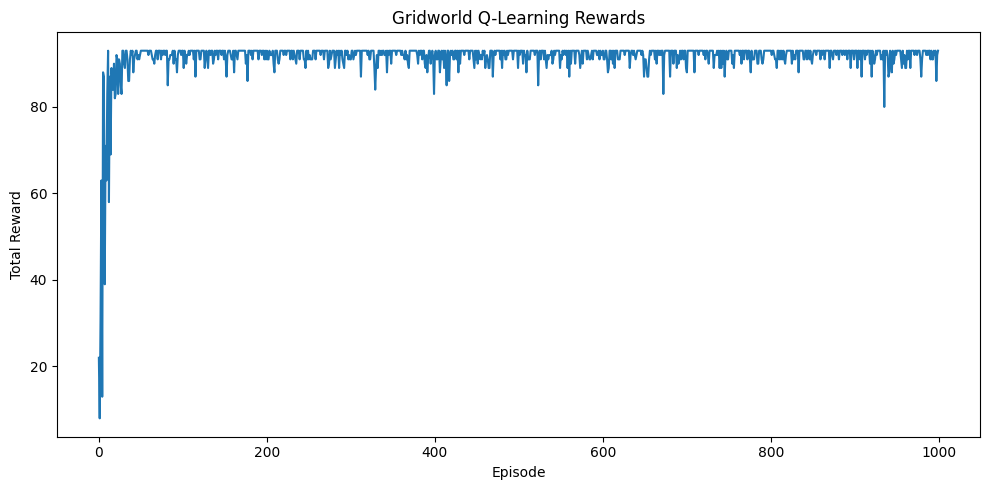


Policy:
↓ ↓ ↓ ↓ ↓
→ ↓ → ↓ ↓
↑ ↓ X → ↓
→ → ↓ X ↓
→ → → → G

--- MountainCar Q-Learning ---


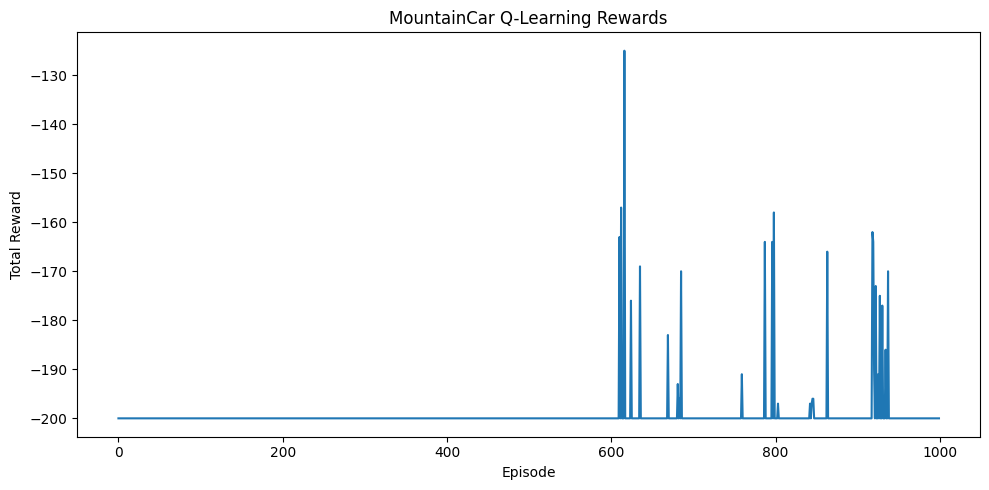

In [5]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import pickle


# Gridworld Environment
class GridworldEnv:
    def __init__(self, size=5):
        self.size = size
        self.start = (0, 0)
        self.goal = (4, 4)
        self.obstacles = [(2, 2), (3, 3)]
        self.state = self.start

        # Actions: Up, Down, Left, Right
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action_idx):
        action = self.actions[action_idx]
        new_state = (self.state[0] + action[0], self.state[1] + action[1])

        # Check boundaries
        if (new_state[0] < 0 or new_state[0] >= self.size or
                new_state[1] < 0 or new_state[1] >= self.size or
                new_state in self.obstacles):
            new_state = self.state

        # Reward structure
        if new_state == self.goal:
            reward = 100
            done = True
        elif new_state in self.obstacles:
            reward = -10
            done = False
        else:
            reward = -1
            done = False

        self.state = new_state
        return new_state, reward, done

    def render(self):
        grid = np.zeros((self.size, self.size))
        grid[self.goal] = 2  # Goal
        for obs in self.obstacles:
            grid[obs] = -1  # Obstacles
        grid[self.state] = 1  # Current state
        print(grid)


def q_learning(env, n_episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    # For Gridworld: states are actual coordinates
    states = [(x, y) for x in range(env.size) for y in range(env.size)]
    n_actions = 4

    # Q-table initialization
    Q = {state: np.zeros(n_actions) for state in states}

    episode_rewards = []

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection
            if np.random.random() < epsilon:
                action = np.random.randint(n_actions)
            else:
                action = np.argmax(Q[state])

            # Take action
            next_state, reward, done = env.step(action)
            total_reward += reward

            # Q-learning update
            best_next_action = np.argmax(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])

            state = next_state

        episode_rewards.append(total_reward)

    return Q, episode_rewards


def visualize_policy(Q, env):
    policy_grid = np.full((env.size, env.size), " ")
    for state, actions in Q.items():
        best_action = np.argmax(actions)
        if state == env.goal:
            policy_grid[state] = "G"
        elif state in env.obstacles:
            policy_grid[state] = "X"
        else:
            policy_grid[state] = ["↑", "↓", "←", "→"][best_action]
    print("\nPolicy:")
    print("\n".join(" ".join(row) for row in policy_grid))


def mountain_car_q_learning(env, n_episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    # Discretize continuous state space
    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)

    # Q-table for discrete states
    Q = np.zeros((len(pos_space), len(vel_space), env.action_space.n))

    episode_rewards = []

    for episode in range(n_episodes):
        # Reset the environment and get the initial state
        reset_result = env.reset()
        if isinstance(reset_result, tuple):
            state = reset_result[0]  # First element is the state
        else:
            state = reset_result  # Handle older Gym versions

        state = np.array(state)  # Ensure state is a flat array

        total_reward = 0
        done = False

        # Digitize initial state
        pos_bin = np.digitize(state[0], pos_space) - 1
        vel_bin = np.digitize(state[1], vel_space) - 1

        # Ensure bins are within valid range
        pos_bin = max(0, min(pos_bin, len(pos_space) - 2))
        vel_bin = max(0, min(vel_bin, len(vel_space) - 2))

        while not done:
            # Epsilon-greedy action selection
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[pos_bin, vel_bin])

            # Take action and handle the new API
            step_result = env.step(action)
            if isinstance(step_result, tuple):
                next_state, reward, done, info = step_result  # Handle Gym API returning 4 values
            else:
                next_state, reward, done = step_result  # Handle older Gym versions

            next_state = np.array(next_state)  # Ensure next_state is a flat array
            total_reward += reward

            # Digitize next state
            next_pos_bin = np.digitize(next_state[0], pos_space) - 1
            next_vel_bin = np.digitize(next_state[1], vel_space) - 1

            # Ensure next bins are within valid range
            next_pos_bin = max(0, min(next_pos_bin, len(pos_space) - 2))
            next_vel_bin = max(0, min(next_vel_bin, len(vel_space) - 2))

            # Q-learning update
            best_next_action = np.argmax(Q[next_pos_bin, next_vel_bin])
            Q[pos_bin, vel_bin, action] += alpha * (
                reward + gamma * Q[next_pos_bin, next_vel_bin, best_next_action] - Q[pos_bin, vel_bin, action]
            )

            # Update state
            pos_bin, vel_bin = next_pos_bin, next_vel_bin
            state = next_state

        episode_rewards.append(total_reward)

    return Q, episode_rewards



def save_q_table(Q, filename):
    with open(filename, 'wb') as f:
        pickle.dump(Q, f)


def load_q_table(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


def plot_rewards(rewards, title):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.tight_layout()
    plt.show()


def main():
    # Part 1: Gridworld Q-Learning
    print("--- Gridworld Q-Learning ---")
    gridworld = GridworldEnv()
    gridworld_Q, gridworld_rewards = q_learning(gridworld)
    plot_rewards(gridworld_rewards, 'Gridworld Q-Learning Rewards')
    visualize_policy(gridworld_Q, gridworld)
    save_q_table(gridworld_Q, 'gridworld_q_table.pkl')

    # Part 2: MountainCar Q-Learning
    print("\n--- MountainCar Q-Learning ---")
    env = gym.make('MountainCar-v0')
    mountain_car_Q, mountain_car_rewards = mountain_car_q_learning(env)
    plot_rewards(mountain_car_rewards, 'MountainCar Q-Learning Rewards')
    save_q_table(mountain_car_Q, 'mountaincar_q_table.pkl')

    # Optional: Render the learned policy for MountainCar
    state = env.reset()
    done = False
    while not done:
        pos_bin = np.digitize(state[0], np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)) - 1
        vel_bin = np.digitize(state[1], np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)) - 1
        action = np.argmax(mountain_car_Q[pos_bin, vel_bin])
        state, _, done, _ = env.step(action)
        env.render()
    env.close()
    env = gym.make('MountainCar-v0', render_mode='human')
    env = gym.make('MountainCar-v0', new_step_api=True)




if __name__ == "__main__":
    main()
